# 1. Подготовка данных

In [64]:
#region import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(25.0, 8.0))
plt.rc('axes', grid=True, xmargin=0)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.tasks.common_metric import mean_quantile_error, rmsle, r2_score
#endregion

In [65]:
#region functions
def evaluate_preds(true_values, pred_values):
    """Оценка качества модели и график preds vs true"""
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')

def count_col (column):
    """Функция описывает частотность значений номинативной или ранговой переменной (продвинутый вариант метода value_counts)"""
    x=pd.concat([column.value_counts(dropna=False), round(column.value_counts(normalize=True, dropna=False)*100,2)], axis=1)
    x.columns = ['Кол-во_записей', 'В %']
    x.sort_values('Кол-во_записей', ascending=False)
    x["В % нараст. итогом"] = x["В %"].cumsum()
    x = x.rename_axis('Значение').reset_index()
    x = x.rename_axis('#')
    x.index +=1
    return x
#endregion

In [66]:
df = pd.concat([pd.read_csv('train.csv'), pd.read_csv('test.csv')])
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   districtid     15000 non-null  int64  
 2   rooms          15000 non-null  float64
 3   square         15000 non-null  float64
 4   lifesquare     11846 non-null  float64
 5   kitchensquare  15000 non-null  float64
 6   floor          15000 non-null  int64  
 7   housefloor     15000 non-null  float64
 8   houseyear      15000 non-null  int64  
 9   ecology_1      15000 non-null  float64
 10  ecology_2      15000 non-null  object 
 11  ecology_3      15000 non-null  object 
 12  social_1       15000 non-null  int64  
 13  social_2       15000 non-null  int64  
 14  social_3       15000 non-null  int64  
 15  healthcare_1   7825 non-null   float64
 16  helthcare_2    15000 non-null  int64  
 17  shops_1        15000 non-null  int64  
 18  shops_2

Из открытых данных известно, что минимальная площадь квартиры, продаваемой в Москве, составляет 8 м2. Отсюда, данные о площади квартир, где значение этого показателя составляет менее 8, недостоверны. Введем для таких квартир отдельный признак is_square_true (0 - площадь недостоверна, 1 - достоверна).
По тренировочной выборке рассчитаем среднюю стоимость 1м2, после чего для квартир с недостоверно указанной плошадью разделим их цену на среднюю стоимость 1м2, и так определим их площадь.
 По тестовой выборке рассчитаем площадь как среднее значение площади по всей выборке. Учитывая малую долю квартир с недостоверно указанной площадью в тестовой выборке (9 из 5000), эта подстановка не должна существенно сказаться на модели.

In [67]:
df.insert(4, 'is_square_true', df.square >= 8)
df.query('is_square_true == 0')

,id,districtid,rooms,square,is_square_true,lifesquare,kitchensquare,floor,housefloor,houseyear,...,ecology_2,ecology_3,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,shops_2,price
161,6782,45,1.0,2.954309,False,5.257278,1.0,3,1.0,1977,...,B,B,23,5212,6,NaN,3,2,B,438005.182323
328,4504,27,3.0,4.390331,False,5.610772,1.0,8,19.0,2016,...,B,B,9,1892,0,NaN,0,1,B,161379.067034
1401,9487,5,1.0,5.129222,False,5.549458,1.0,1,1.0,1977,...,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4496,15744,34,1.0,1.988943,False,2.642219,1.0,21,4.0,1977,...,B,B,53,13670,4,NaN,1,11,B,458378.777006
4800,7657,38,1.0,4.502784,False,4.618547,1.0,28,1.0,1977,...,B,B,15,2787,2,520.0,0,7,B,483283.488083
5009,11526,27,1.0,4.633498,False,1.969969,1.0,18,1.0,1977,...,B,B,4,915,0,NaN,0,0,B,107604.269441
7033,1748,88,2.0,5.497061,False,67.628717,1.0,24,22.0,1977,...,B,B,43,8429,3,NaN,3,9,B,412511.088764
7470,14786,1,1.0,1.136859,False,4.525736,1.0,3,1.0,1977,...,B,B,1,264,0,NaN,0,1,B,181434.825589
8572,10202,6,1.0,2.596351,False,4.604943,1.0,3,25.0,2014,...,B,B,5,1564,0,540.0,0,0,B,137597.601458
8805,10527,27,1.0,4.380726,False,40.805837,1.0,10,17.0,2013,...,B,B,9,1892,0,NaN,0,1,B,97560.720383


In [68]:
av_m2_price = (df.query('square >=8').price/df.query('square >=8').square).mean()
df.square = np.where((df.is_square_true == 0) & (df.price == df.price), df.price/av_m2_price, df.square)
df.square = np.where((df.is_square_true == 0) & (df.price != df.price), df.square.mean(), df.square)

In [69]:
count_col(df.rooms)

,Значение,Кол-во_записей,В %,В % нараст. итогом
#,,,,
1,2.0,5910,39.40,39.40
2,1.0,5474,36.49,75.89
3,3.0,3334,22.23,98.12
4,4.0,240,1.60,99.72
5,5.0,25,0.17,99.89
6,0.0,10,0.07,99.96
7,6.0,3,0.02,99.98
8,10.0,2,0.01,99.99
9,19.0,1,0.01,100.00


10 записей о числе комнат недостоверны: в квартире не может быть 0 комнат. Посчитаем среднюю площадь одной комнаты для всей выборки (исходя из общей площади, т к жилая площадь заполнена не везде), после чего для тех квартир, где число комнат = 0,разделим общую площадь на среднюю площадь одной комнаты, получившееся значение округлим до целого. Аналогично предыдущему пункту, выделим квартиры с недостоверным числом комнат вотдельную фичу.

In [70]:
df.insert(3, 'is_rooms_true', df.rooms != 0)
df.query('is_rooms_true==0')

,id,districtid,rooms,is_rooms_true,square,is_square_true,lifesquare,kitchensquare,floor,housefloor,...,ecology_2,ecology_3,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,shops_2,price
2194,3159,88,0.0,False,38.697117,True,19.345131,9.0,9,16.0,...,B,B,43,8429,3,NaN,3,9,B,158998.110646
3780,7317,27,0.0,False,41.790881,True,NaN,0.0,13,0.0,...,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,False,49.483501,True,NaN,0.0,16,0.0,...,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6401,9443,27,0.0,False,87.762616,True,85.125471,0.0,5,15.0,...,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,False,212.932361,True,211.231125,0.0,2,3.0,...,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,False,81.491446,True,NaN,0.0,4,0.0,...,B,B,5,1564,0,540.0,0,0,B,212864.799112
9767,12638,27,0.0,False,138.427694,True,136.215499,0.0,4,3.0,...,B,B,11,3097,0,NaN,0,0,B,268394.744389
9869,3224,27,0.0,False,32.544189,False,0.873147,0.0,1,0.0,...,B,B,2,469,0,NaN,0,0,B,126596.941798
961,3343,58,0.0,False,116.824201,True,113.692424,0.0,3,3.0,...,B,B,23,5735,3,1084.0,0,5,B,NaN
4179,10729,27,0.0,False,76.345154,True,42.820796,12.0,14,0.0,...,B,B,2,469,0,NaN,0,0,B,NaN


In [71]:
av_room_square = (df.query('is_rooms_true == 1').square/df.query('is_rooms_true == 1').rooms).mean()
df.rooms = np.where(df.is_rooms_true == 0, round(df.square/av_room_square,0), df.rooms)

Данные по жилой площади могут быть признаны достоверными, еслиони одновременно соответствуют следующим требованиям:
1. Доля жилой площади в общей площади составляет не менее 40% (в квартире должны преобладать жилые комнаты, а не коридоры и кухни),
2. Разница между общей площадью, жилой площадью и площадью кухни составляет не менее 2 м2 (минимальная площадь санузла),
3. Размер жилой площади составляет не менее 6м2 (минимальная общая площадь минус минимальная площадь санузла).

In [72]:
mask = (df.lifesquare==df.lifesquare) & (df.lifesquare >=6) & (df.square - df.lifesquare - df.kitchensquare >=2) & (df.lifesquare/df.square >=0.4)
df.insert(7, 'is_lifesquare_true', mask)
df.query('is_lifesquare_true == 0')

,id,districtid,rooms,is_rooms_true,square,is_square_true,lifesquare,is_lifesquare_true,kitchensquare,floor,...,ecology_2,ecology_3,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,shops_2,price
0,11809,27,3.0,True,115.027311,True,NaN,False,10.0,4,...,B,B,11,3097,0,NaN,0,0,B,305018.871089
3,2352,1,1.0,True,40.409907,True,NaN,False,1.0,10,...,B,B,1,264,0,NaN,0,1,B,168106.007630
8,9951,1,1.0,True,46.887892,True,44.628132,False,1.0,12,...,B,B,1,264,0,NaN,0,1,B,160400.401732
18,4581,1,1.0,True,47.582480,True,NaN,False,1.0,16,...,B,B,1,264,0,NaN,0,1,B,128803.593810
19,367,45,1.0,True,42.367289,True,40.012529,False,1.0,16,...,B,B,23,5212,6,NaN,3,2,B,250466.980777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4988,11890,1,2.0,True,66.683295,True,NaN,False,1.0,6,...,B,B,1,264,0,NaN,0,1,B,NaN
4989,13069,1,2.0,True,61.747208,True,NaN,False,0.0,5,...,B,B,1,264,0,NaN,0,1,B,NaN
4993,14676,6,1.0,True,48.435108,True,NaN,False,1.0,18,...,B,B,5,1564,0,540.0,0,0,B,NaN
4994,13060,25,2.0,True,51.144906,True,48.979540,False,1.0,18,...,B,B,53,13670,4,NaN,1,11,B,NaN


Из 15000 записей 5198 записей (35%) в отношении жилой площади недостоверны, либо вообще не заполнены. Отсюда, данный показатель не может быть признан достаточно надежным. Возможно, при построении модели его будет необходимо исключить.
Пока заполним неправильные значения пропорционально средней доле жилой площади в общей площади для 'правильной' части выборки.

In [73]:
lifesq_share = (df.query('is_lifesquare_true == 1').lifesquare/df.query('is_lifesquare_true == 1').square).mean()
df.lifesquare = np.where(df.is_lifesquare_true == 0, df.square*lifesq_share, df.lifesquare)

Квартира может быть без отдельной кухни (например, кухня совмещена с гостиной). Но в любом случае, примем, что площадь кухни плюс минимальная площадь санузла не должны прeвышать 60% от площади квартиры. Там, где это требование нарушено, изменим площадь кухни пропорционально доли площади кухни в общей площади для оставшейся выборки.

In [74]:
df.insert(9, 'is_kitchen_true', (df.kitchensquare + 2)/df.square < 0.6)

In [75]:
df.query('is_kitchen_true == 0')

,id,districtid,rooms,is_rooms_true,square,is_square_true,lifesquare,is_lifesquare_true,kitchensquare,is_kitchen_true,...,ecology_2,ecology_3,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,shops_2,price
286,2737,27,3.0,True,123.430072,True,75.517350,False,123.0,False,...,B,B,2,469,0,NaN,0,0,B,234194.837047
456,10546,62,1.0,True,46.013187,True,28.151924,False,43.0,False,...,B,B,2,629,1,NaN,0,0,A,113909.099428
682,16593,52,2.0,True,64.859242,True,39.682372,False,62.0,False,...,B,B,34,7065,1,750.0,2,5,B,185993.474671
755,15781,10,1.0,True,35.813564,True,21.911560,False,35.0,False,...,B,B,33,8667,2,NaN,0,6,B,164306.314182
1728,16395,2,3.0,True,79.722243,True,48.775897,False,72.0,False,...,B,B,39,10418,9,900.0,1,9,B,370148.625285
2108,2271,27,1.0,True,43.292516,True,26.487354,False,40.0,False,...,B,B,9,1892,0,NaN,0,1,B,117296.173704
2454,12390,72,3.0,True,97.490674,True,59.647031,False,96.0,False,...,B,B,11,2398,2,1994.0,3,0,B,445074.956552
2702,1315,6,1.0,True,48.128114,True,29.445884,False,48.0,False,...,B,B,5,1564,0,540.0,0,0,B,146950.912410
2785,6569,27,1.0,True,38.220258,True,23.384031,False,84.0,False,...,B,B,4,915,0,NaN,0,0,B,99079.960518
2831,12507,54,2.0,True,79.810535,True,48.829916,False,78.0,False,...,B,B,30,5285,0,645.0,6,6,B,438708.707579


In [76]:
kitchen_share = (df.query('is_kitchen_true == 1').kitchensquare/df.query('is_kitchen_true == 1').square).mean()
df.kitchensquare = np.where(df.is_kitchen_true == 0, df.square*kitchen_share, df.kitchensquare)

In [77]:
df['square_check'] = (df.square - df.lifesquare - df.kitchensquare - 2 >= 0)
df.query('square_check == 0')

,id,districtid,rooms,is_rooms_true,square,is_square_true,lifesquare,is_lifesquare_true,kitchensquare,is_kitchen_true,...,ecology_3,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,shops_2,price,square_check
1561,5921,27,1.0,True,30.786315,True,18.835774,False,10.0,True,...,B,9,1892,0,NaN,0,1,B,87966.764052,False
2180,5826,23,1.0,True,55.282148,True,33.822886,False,20.0,True,...,B,2,475,0,NaN,0,0,B,157140.848998,False
2307,5939,23,1.0,True,29.109535,True,17.809881,False,10.0,True,...,B,0,168,0,NaN,0,0,B,69237.912649,False
3220,10993,23,1.0,True,30.907045,True,18.909639,False,10.0,True,...,B,0,168,0,NaN,0,0,B,66630.740772,False
3976,16575,27,1.0,True,32.712359,True,20.014172,False,13.0,True,...,B,2,629,1,NaN,0,0,A,94433.038958,False
4499,8090,23,1.0,True,30.388774,True,18.592549,False,10.0,True,...,B,0,168,0,NaN,0,0,B,81675.493799,False
4931,3538,23,1.0,True,27.293799,True,16.698972,False,10.0,True,...,B,0,168,0,NaN,0,0,B,75695.826241,False
6794,13288,161,1.0,True,50.808925,True,31.086066,False,20.0,True,...,B,19,3806,4,NaN,0,3,B,287954.720682,False
8237,194,23,1.0,True,40.089322,True,24.527567,False,15.0,True,...,B,0,168,0,NaN,0,0,B,81258.057035,False
8305,1300,23,1.0,True,28.827565,True,17.637366,False,10.0,True,...,B,0,168,0,NaN,0,0,B,73162.636079,False


После проведенных исправлений осталось еще 20 записей, в которых площадь кухни, жилая площадь и минимальная площадь санузла в сумме превосходят общую площадь. Учитвая, что по всем этим записям значение жилой площади получено расчетным путем (изначально являлось недостоверным), откорректируем эти записи путем корректировки размера жилой площади.

In [78]:
df.lifesquare = np.where(df.square_check == 0,df.square - df.kitchensquare - 2, df.lifesquare)
df.drop('square_check',axis=1,inplace=True)

In [79]:
count_col(df.housefloor)

,Значение,Кол-во_записей,В %,В % нараст. итогом
#,,,,
1,17.0,3482,23.21,23.21
2,9.0,2113,14.09,37.30
3,12.0,1600,10.67,47.97
4,5.0,1581,10.54,58.51
5,14.0,969,6.46,64.97
6,16.0,811,5.41,70.38
7,1.0,727,4.85,75.23
8,25.0,553,3.69,78.92
9,22.0,536,3.57,82.49


Самое высокое жилое здание в Москве имеет 95 этажей. Крайне маловероятны квартиры в одноэтажных жилых домах. отсюда, достоверные значения этажности лежат в диапазоне (2,95).
Кроме того, этажность не может быть больше этажа продаваемой квартиры. Конечно, в этом случае ошибка может быть и в этаже самой квартиры, а не в общем числе этажей дома, но все же представляется, что вероятность неправильно указать общую этажность выше,чем ошибиться в этаже конкретной квартиры (дома бывают переменной этажности, влияют технические этажи, мансарды, подвалы и т п.). Поэтому будем корректировать параметр housefloor

In [80]:
df.insert(12, 'is_housefloor_true', (df.housefloor > 1) & (df.housefloor <=95) & (df.housefloor >=df.floor))

In [81]:
df.query('is_housefloor_true == 0')

,id,districtid,rooms,is_rooms_true,square,is_square_true,lifesquare,is_lifesquare_true,kitchensquare,is_kitchen_true,...,ecology_2,ecology_3,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,shops_2,price
17,1190,8,2.0,True,49.396000,True,28.299600,True,5.0,True,...,B,A,26,4439,1,1130.0,1,5,B,186971.926566
19,367,45,1.0,True,42.367289,True,25.921279,False,1.0,True,...,B,B,23,5212,6,NaN,3,2,B,250466.980777
21,8471,20,3.0,True,75.611065,True,47.494621,True,8.0,True,...,B,B,37,7687,11,176.0,5,5,B,366916.246494
24,4717,27,1.0,True,44.203947,True,27.044989,False,0.0,True,...,B,B,2,629,1,NaN,0,0,A,135466.559958
25,4521,6,2.0,True,65.409965,True,40.019317,False,1.0,True,...,B,B,5,1564,0,540.0,0,0,B,191205.272608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,14793,27,1.0,True,47.295978,True,28.936764,False,10.0,True,...,B,B,2,629,1,NaN,0,0,A,NaN
4978,15243,53,2.0,True,56.872925,True,34.796161,False,0.0,True,...,B,B,34,7759,0,229.0,1,3,B,NaN
4980,11709,63,1.0,True,51.872447,True,31.736753,False,1.0,True,...,B,B,26,3889,6,705.0,3,6,B,NaN
4982,8197,9,1.0,True,38.595211,True,22.895884,True,8.0,True,...,B,B,25,5648,1,30.0,2,4,B,NaN


Заменим недостоверные значения этажности домов на максимальные значения этажей квартир из сделок по этим домам. Так как ID домов у нас нет, то максимальной точности мы можем добиться, сгруппировав квартиры по id района и году постройки и взяв из полученной группировки максимальное значение фичи floor

In [82]:
df=df.reset_index(drop=True)
df['foo'] = df.query('is_housefloor_true == 0').groupby(['districtid', 'houseyear'])['floor'].transform(max)
df.housefloor = np.where(df.is_housefloor_true == 0, df.foo ,df.housefloor)
df.drop('foo', axis=1, inplace=True)
count_col(df.housefloor)

,Значение,Кол-во_записей,В %,В % нараст. итогом
#,,,,
1,17.0,3335,22.23,22.23
2,9.0,1869,12.46,34.69
3,12.0,1456,9.71,44.40
4,5.0,1251,8.34,52.74
5,14.0,961,6.41,59.15
6,16.0,792,5.28,64.43
7,25.0,629,4.19,68.62
8,26.0,570,3.80,72.42
9,22.0,525,3.50,75.92


In [83]:
count_col(df.floor)

,Значение,Кол-во_записей,В %,В % нараст. итогом
#,,,,
1,4,1472,9.81,9.81
2,5,1371,9.14,18.95
3,3,1278,8.52,27.47
4,6,1207,8.05,35.52
5,7,1106,7.37,42.89
6,8,970,6.47,49.36
7,9,902,6.01,55.37
8,2,851,5.67,61.04
9,10,820,5.47,66.51


In [84]:
#Проверка правильности корректировки
(df.floor <= df.housefloor) & (df.housefloor > 1) & (df.housefloor <= 95)

0        True
1        True
2        True
3        True
4        True
         ... 
14995    True
14996    True
14997    True
14998    True
14999    True
Length: 15000, dtype: bool

In [85]:
df.insert(11,'is_first_floor', df.floor==1)
df.insert(12,'is_last_floor', df.floor==df.housefloor)

In [86]:
count_col(df.houseyear)

,Значение,Кол-во_записей,В %,В % нараст. итогом
#,,,,
1,1977,3950,26.33,26.33
2,2016,477,3.18,29.51
3,2015,458,3.05,32.56
4,2017,449,2.99,35.55
5,2014,308,2.05,37.60
...,...,...,...,...
101,1949,1,0.01,99.96
102,1908,1,0.01,99.97
103,1920,1,0.01,99.98


In [87]:
df.query('houseyear==1977')

,id,districtid,rooms,is_rooms_true,square,is_square_true,lifesquare,is_lifesquare_true,kitchensquare,is_kitchen_true,...,ecology_2,ecology_3,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,shops_2,price
3,2352,1,1.0,True,40.409907,True,24.723708,False,1.0,True,...,B,B,1,264,0,NaN,0,1,B,168106.007630
8,9951,1,1.0,True,46.887892,True,28.687088,False,1.0,True,...,B,B,1,264,0,NaN,0,1,B,160400.401732
18,4581,1,1.0,True,47.582480,True,29.112053,False,1.0,True,...,B,B,1,264,0,NaN,0,1,B,128803.593810
24,4717,27,1.0,True,44.203947,True,27.044989,False,0.0,True,...,B,B,2,629,1,NaN,0,0,A,135466.559958
25,4521,6,2.0,True,65.409965,True,40.019317,False,1.0,True,...,B,B,5,1564,0,540.0,0,0,B,191205.272608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14978,15243,53,2.0,True,56.872925,True,34.796161,False,0.0,True,...,B,B,34,7759,0,229.0,1,3,B,NaN
14985,2812,120,2.0,True,81.488501,True,49.856535,False,1.0,True,...,B,B,27,5664,48,2300.0,3,11,B,NaN
14988,11890,1,2.0,True,66.683295,True,40.798370,False,1.0,True,...,B,B,1,264,0,NaN,0,1,B,NaN
14989,13069,1,2.0,True,61.747208,True,37.778358,False,0.0,True,...,B,B,1,264,0,NaN,0,1,B,NaN


Обращает на себя внимание аномально высокая (26%) доля домов 1977 года постройки (для сравнения дома 1976 года постройки составляют 1,6%, 1978го - 1,3% от общего числа). Если проанализировать записи, относящиеся к 1977 году, то можно найти квартиры площадью более 100м2 и менее 30м2, квартиры без кухонь, дома в 25 и выше этажей, что абсолютно нетипично для жилищного строительства той эпохи.
 Можно уверенно говорить о недостоверности таких записей, причем определить, когда на самом деле был построен тот или иной дом, не представляется возможным.
Кроме того, техническое состояние дома и его комфортность не имеет прямой связи с годом его постройки. Квартиры в центре Москвы в дореволюционном доме после капремонта могут стоить намного дороже, чем в современном жилье эконом-класса или в хрущевке. Здесь больше влияет район, наличие капремонта, серия и тип дома, а не год его постройки.
В связи с этим данный столбец следует исключить из анализа.

In [88]:
df.drop('houseyear', axis=1,inplace=True)

In [89]:
count_col(df.ecology_2)

,Значение,Кол-во_записей,В %,В % нараст. итогом
#,,,,
1,B,14855,99.03,99.03
2,A,145,0.97,100.00


In [90]:
count_col(df.query('ecology_2 == "A"').districtid)

,Значение,Кол-во_записей,В %,В % нараст. итогом
#,,,,
1,101,110,75.86,75.86
2,57,15,10.34,86.20
3,11,9,6.21,92.41
4,71,8,5.52,97.93
5,192,3,2.07,100.00


In [91]:
df.groupby(['districtid', 'ecology_2']).size()

districtid  ecology_2
0           B             67
1           B            996
2           B            121
3           B            138
4           B             19
                        ... 
208         B              3
209         B              3
210         B              1
211         B              1
212         B              1
Length: 217, dtype: int64

Значение поля ecology_2 крайне несбалансировано (более 99% принадежит к одному из типов). Меньший тип на 75% связан с одним из районов (dictrictid 101). Из 145 записей с типом экологии "В" 110 (76%) относятся к району №101, в котором всего было продано 143 квартиры (доля 77%). Из-за высокой несбалансированности и дублирования столбец ecology_2 следует исключить.

In [92]:
df.drop('ecology_2', axis=1,inplace=True)

In [93]:
count_col(df.ecology_3)

,Значение,Кол-во_записей,В %,В % нараст. итогом
#,,,,
1,B,14576,97.17,97.17
2,A,424,2.83,100.00


In [94]:
df.query('ecology_3 == "A"')

,id,districtid,rooms,is_rooms_true,square,is_square_true,lifesquare,is_lifesquare_true,kitchensquare,is_kitchen_true,...,ecology_1,ecology_3,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,shops_2,price
17,1190,8,2.0,True,49.396000,True,28.299600,True,5.0,True,...,0.458174,A,26,4439,1,1130.0,1,5,B,186971.926566
134,16407,31,1.0,True,35.461752,True,19.262117,True,6.0,True,...,0.151346,A,32,5889,10,830.0,4,1,B,183658.925226
189,5810,8,1.0,True,43.488871,True,19.146728,True,8.0,True,...,0.458174,A,26,4439,1,1130.0,1,5,B,203558.797804
231,10190,8,2.0,True,52.960125,True,30.426607,True,7.0,True,...,0.458174,A,26,4439,1,1130.0,1,5,B,211197.302549
265,15204,8,1.0,True,38.377791,True,22.552305,True,8.0,True,...,0.458174,A,26,4439,1,1130.0,1,5,B,156705.710131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14891,16230,79,1.0,True,41.211826,True,19.608551,True,9.0,True,...,0.307467,A,30,5048,9,325.0,2,5,B,NaN
14892,13079,79,1.0,True,35.091915,True,23.645244,True,9.0,True,...,0.307467,A,30,5048,9,325.0,2,5,B,NaN
14915,16611,8,1.0,True,33.301429,True,19.665641,True,5.0,True,...,0.458174,A,26,4439,1,1130.0,1,5,B,NaN
14921,10375,106,1.0,True,35.575157,True,17.941608,True,10.0,True,...,0.246032,A,22,3151,4,2715.0,3,3,B,NaN


С полем ecology_3 ситуация чуть лучше и на первый взгляд незаметно дублирование с другими полями. Так как в поле только 2 значения, переведем его в бинарный формат.

In [95]:
df.insert(16,'is_ecology_3', df.ecology_3 == "B")
df.drop('ecology_3',axis=1,inplace=True)

In [96]:
count_col(df.healthcare_1)

,Значение,Кол-во_записей,В %,В % нараст. итогом
#,,,,
1,NaN,7175,47.83,47.83
2,540.0,768,5.12,52.95
3,30.0,511,3.41,56.36
4,1046.0,365,2.43,58.79
5,750.0,235,1.57,60.36
...,...,...,...,...
76,32.0,19,0.13,99.73
77,1815.0,19,0.13,99.86
78,920.0,19,0.13,99.99


Почти половина поля healthcare_1 не заполнена. Так как о реальном содержании этого поля ничего не известно, заполнить эти пропуски по аналогии с другими полями не представляется возможным. Поле следует удалить

In [97]:
df.drop('healthcare_1',axis=1,inplace=True)

In [98]:
count_col(df.shops_2)

,Значение,Кол-во_записей,В %,В % нараст. итогом
#,,,,
1,B,13763,91.75,91.75
2,A,1237,8.25,100.00


С полем shops_2 следует посnупить аналогично полю ecology_2

In [99]:
df.insert(22,'is_shops_2', df.shops_2 == "B")
df.drop('shops_2',axis=1,inplace=True)

In [100]:
#В результате анализа было введено 5 столбцов, содержащих бинарную информацию о достоверности площади, жилой площади, площади кухни, количества комнат и этажности дома.
#Сумма этих столбцов даст некий "рейтинг достоверности" для каждой записи, где 5 - максимальное значение (все поля были достоверными), 0 - минимальное.
df['truth_rating'] = df.filter(like='true',axis=1).sum(axis=1)
count_col(df.truth_rating)

,Значение,Кол-во_записей,В %,В % нараст. итогом
#,,,,
1,5,8525,56.83,56.83
2,4,4971,33.14,89.97
3,3,1478,9.85,99.82
4,2,25,0.17,99.99
5,1,1,0.01,100.00


In [101]:
df.query('truth_rating <=2 and price > 0')

,id,districtid,rooms,is_rooms_true,square,is_square_true,lifesquare,is_lifesquare_true,kitchensquare,is_kitchen_true,...,ecology_1,is_ecology_3,social_1,social_2,social_3,helthcare_2,shops_1,is_shops_2,price,truth_rating
161,6782,45,1.0,True,112.597693,False,68.889852,False,1.000000,True,...,0.195781,True,23,5212,6,3,2,True,438005.182323,2
1401,9487,5,1.0,True,94.980019,False,58.110954,False,1.000000,True,...,0.150818,True,16,3433,4,4,5,True,369472.403061,2
2108,2271,27,1.0,True,43.292516,True,26.487354,False,4.748764,False,...,0.211401,True,9,1892,0,0,1,True,117296.173704,2
2702,1315,6,1.0,True,48.128114,True,29.445884,False,5.279182,False,...,0.243205,True,5,1564,0,0,0,True,146950.912410,2
3240,2371,27,2.0,True,68.841073,True,42.118548,False,7.551190,False,...,0.017647,True,2,469,0,0,0,True,189244.249909,2
3780,7317,27,1.0,False,41.790881,True,25.568620,False,0.000000,True,...,0.211401,True,9,1892,0,0,1,True,98129.976788,2
4496,15744,34,1.0,True,117.835120,False,72.094230,False,1.000000,True,...,0.069753,True,53,13670,4,1,11,True,458378.777006,2
4800,7657,38,1.0,True,124.237357,False,76.011265,False,1.000000,True,...,0.060753,True,15,2787,2,0,7,True,483283.488083,2
5009,11526,27,1.0,True,27.661756,False,16.924097,False,1.000000,True,...,0.011654,True,4,915,0,0,0,True,107604.269441,2
5894,770,28,2.0,False,49.483501,True,30.275141,False,0.000000,True,...,0.118537,True,30,6207,1,1,0,True,217009.338463,2


В тренировочном датасете 16 записей имеют рейтинг достоверности - 2, и 1 запись - рейтинг 1. Эти запись следует удалить как недостоверные.

In [102]:
df = df.query('truth_rating > 2 or price!=price')

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14983 entries, 0 to 14999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  14983 non-null  int64  
 1   districtid          14983 non-null  int64  
 2   rooms               14983 non-null  float64
 3   is_rooms_true       14983 non-null  bool   
 4   square              14983 non-null  float64
 5   is_square_true      14983 non-null  bool   
 6   lifesquare          14983 non-null  float64
 7   is_lifesquare_true  14983 non-null  bool   
 8   kitchensquare       14983 non-null  float64
 9   is_kitchen_true     14983 non-null  bool   
 10  floor               14983 non-null  int64  
 11  is_first_floor      14983 non-null  bool   
 12  is_last_floor       14983 non-null  bool   
 13  housefloor          14983 non-null  float64
 14  is_housefloor_true  14983 non-null  bool   
 15  ecology_1           14983 non-null  float64
 16  is_e

В результате этапа была проанализирована полнота и достоверность данных, убраны несбалансированные, нерелевантные и дублирующие фичи (год постройки, ряд социальныхпоказателей), введены новые фичи (признак первого, последнего этажа).  Там, где это возможно, пропуски и недостоверные записи заменены, исходя из содержания сходных записей и полей. Где невозможно - записи из тренировочного сета удалены.
В целом только 57% записей первоначального датафрейма могут быть признаны непротиворечивыми. Остальные имеют одно или больше полей, противоречащих друг другу (жилая площадь больше общей, этаж квартиры больше числа этажей в доме и т. п.). Особенно 'грязными' являются поля "Жилая площадь" и "Этажность", в дальнейшем на них надо обратить особое внимание.

# 2.Исследовательский анализ данных

In [104]:
train = df.query('price == price')
test = df.query('price != price')

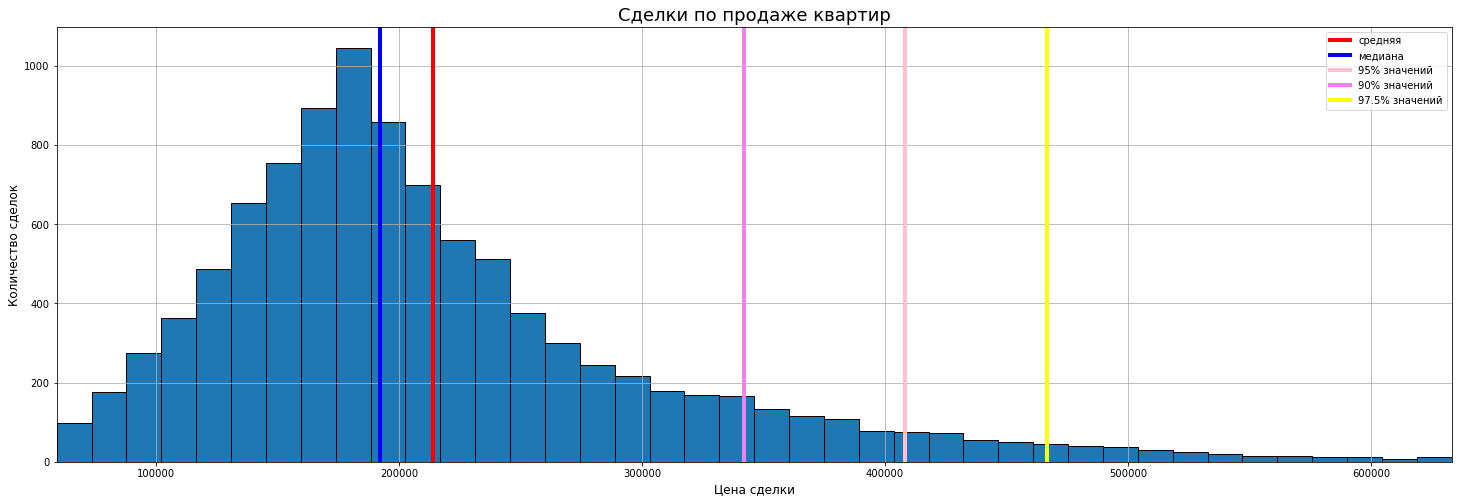

In [105]:
plt.hist(train.price, bins=40,  ec='black')
plt.axvline(train.price.mean(), color='r', linewidth=4, label= 'средняя')
plt.axvline(train.price.median(), color='b', linewidth=4, label= 'медиана')
plt.axvline(train.price.quantile(0.95), color='pink', linewidth=4, label= '95% значений')
plt.axvline(train.price.quantile(0.9), color='violet', linewidth=4, label= '90% значений')
plt.axvline(train.price.quantile(0.975), color='yellow', linewidth=4, label= '97.5% значений')
plt.xlabel('Цена сделки', fontsize=12)
plt.ylabel('Количество сделок', fontsize=12)
plt.title('Сделки по продаже квартир',fontsize=18)
plt.legend()
plt.show()

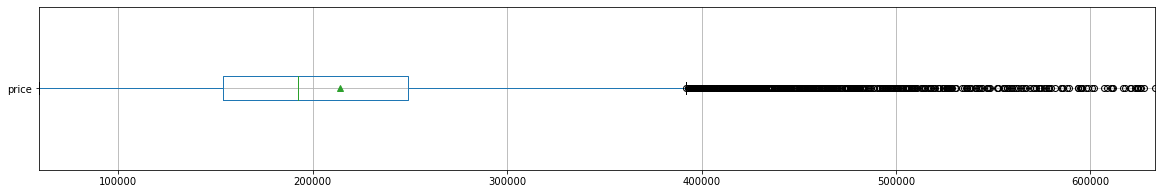

In [106]:
train.boxplot(column=['price'], figsize = (20,3), vert=False, showmeans=True);

Из диаграмм видна смещенность целевой переменной вправо: 95% сделок лежат в пределах 410000 долл, тогда как максимальная цена сделки превышает 600000. Отсюда, в выборке существует подвыборка (2-3%) элитной недвижимости, цены на которую не подчиняются общему правилу. Исключим такие записи из выборки.

In [107]:
df = df[df.price < df.price.quantile(0.975)]

In [108]:
#Переменная districtiD по сути является категориальной, номера районов условны. Присвоим районам числовые наименования, исходя из среднего значения целевой переменной со сглаживанием.
mean = df.price.mean()
agg =df.groupby('districtid').price.agg(['count', 'mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = round((counts*means + weight*mean)/(counts + weight), 1)
df.districtid = df.districtid.map(smooth)

In [109]:
#Построим матрицу корреляции фичей и целевой переменной, причем сделаем ее отдельно для всей выборки,
# полностью достоверных записей (которые не подвергались правке на предыдущем этапе  и имеют рейтинг достоверности 5),
# и записей с рейтином 3 и 4. Это нужно для того, чтобы оценить, стоит ли исключать частично недостоверные записи при постороениии модели или нет.
all = train.drop(['id', 'truth_rating'],axis=1).select_dtypes(exclude='bool').corr().price
train_2 = train.query('truth_rating == 3').drop(['id', 'truth_rating'],axis=1).select_dtypes(exclude='bool').corr().price
train_3 = train.query('truth_rating == 4').drop(['id', 'truth_rating'],axis=1).select_dtypes(exclude='bool').corr().price
train_4 = train.query('truth_rating == 5').drop(['id', 'truth_rating'],axis=1).select_dtypes(exclude='bool').corr().price
x = round(abs(pd.concat([all, train_2,train_3,train_4],axis=1)).drop('price'),3)
x.columns = ['all','truth_rating = 3', 'truth_rating = 4', 'truth_rating = 5']
x.loc['total'] = x.sum()
x.sort_values('all', ascending=False)

,all,truth_rating = 3,truth_rating = 4,truth_rating = 5
total,3.388,3.690,3.500,3.437
rooms,0.552,0.516,0.529,0.564
square,0.525,0.473,0.475,0.660
lifesquare,0.498,0.470,0.476,0.587
kitchensquare,0.315,0.029,0.244,0.344
districtid,0.266,0.227,0.255,0.213
social_1,0.263,0.464,0.368,0.059
helthcare_2,0.253,0.446,0.322,0.123
social_2,0.239,0.409,0.352,0.053
shops_1,0.180,0.180,0.144,0.164


Более всего на цену влияют количество комнат, общая и жилая площадь, площадь кухни. Ни один из признаков не является определяющим (максимальное значение коэфф коррелляции 0.55).

Исключение из выборки недостоверных записей дает существенный рост коэфф. корреляции по тем признакам, где  была обнаружена недостоверность (комнаты, площадь, этажность). Таким образом, проведенные в предыдущей главе операции с этими фичами были правильными.  В то же время, по ряду дополнительных признаков (social1, helthcare2, social2 и др.) наблюдается обратная картина: по тем записям, где были указаны неправильные данные о площади, этажности и т. п. корреляция этих признаков с ценой существенно выше, чем по 'нормальным' записям. Возможно, это связано со спецификой района или особенностями методики определения этих показателей. В этой связи исключать из выборки записи с низким "рейтингом достоверности" не стоит. Будем строить
модель по всей выборке.

In [110]:
abs(round(df.select_dtypes(exclude='bool').drop(['price', 'id'], axis=1).corr(), 2))

,districtid,rooms,square,lifesquare,kitchensquare,floor,housefloor,ecology_1,social_1,social_2,social_3,helthcare_2,shops_1,truth_rating
districtid,1.00,0.10,0.04,0.04,0.35,0.01,0.23,0.05,0.61,0.56,0.01,0.42,0.32,0.38
rooms,0.10,1.00,0.66,0.69,0.11,0.01,0.06,0.03,0.07,0.07,0.00,0.05,0.04,0.07
square,0.04,0.66,1.00,0.95,0.08,0.11,0.18,0.06,0.09,0.06,0.03,0.05,0.01,0.14
lifesquare,0.04,0.69,0.95,1.00,0.01,0.07,0.13,0.05,0.09,0.07,0.03,0.04,0.00,0.13
kitchensquare,0.35,0.11,0.08,0.01,1.00,0.02,0.16,0.03,0.38,0.35,0.08,0.22,0.11,0.57
floor,0.01,0.01,0.11,0.07,0.02,1.00,0.52,0.01,0.05,0.02,0.00,0.07,0.02,0.24
housefloor,0.23,0.06,0.18,0.13,0.16,0.52,1.00,0.09,0.25,0.18,0.00,0.22,0.06,0.46
ecology_1,0.05,0.03,0.06,0.05,0.03,0.01,0.09,1.00,0.03,0.01,0.12,0.04,0.07,0.07
social_1,0.61,0.07,0.09,0.09,0.38,0.05,0.25,0.03,1.00,0.96,0.02,0.53,0.53,0.43
social_2,0.56,0.07,0.06,0.07,0.35,0.02,0.18,0.01,0.96,1.00,0.07,0.48,0.56,0.37


При рассмотрении корреляции фичей между собой заметна высокая корреляция между общей и жилой площадью (0.95). Ранее была показана высокая недостоверность показателя жилой площади. В связи с этим предалагается при построении модели данный показатель удалить.

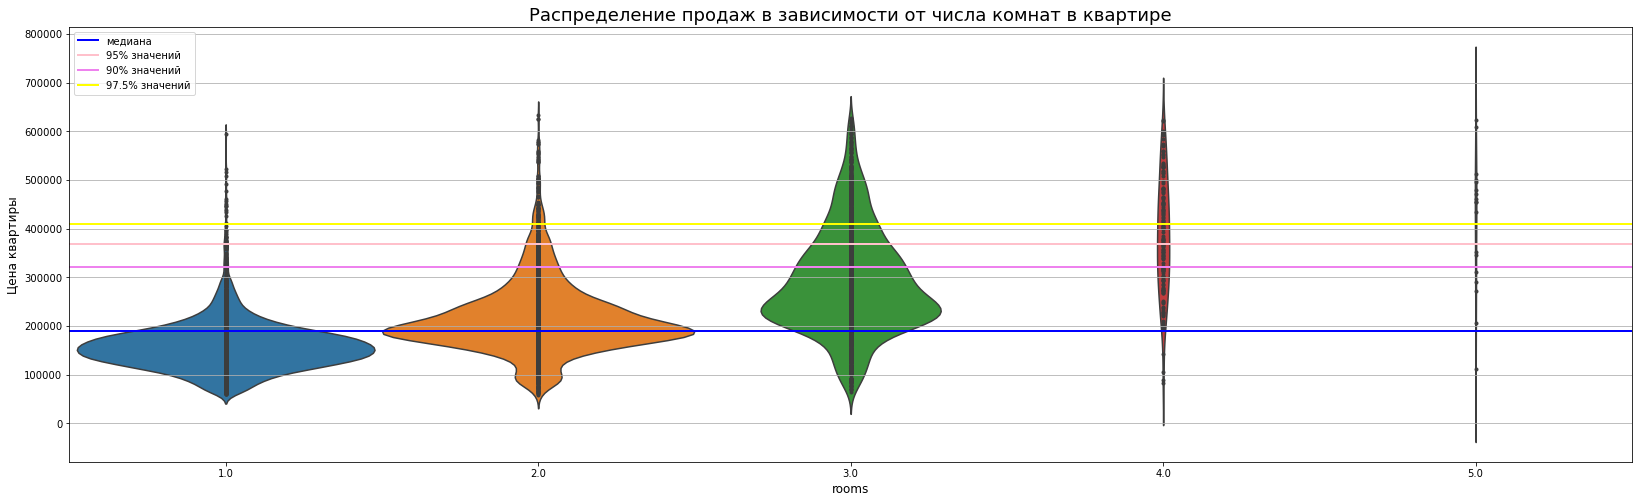

In [111]:
#На диаграмме для наглядности  и сопоставимости не показаны экстремальные значения показателя (больше 5).
price=train.query('rooms <=5')[['rooms', 'price']].reset_index().set_index(['index', 'rooms']).unstack(level=1)
price.columns = price.columns.get_level_values(1)
plt.figure(figsize = (28, 8))
plt.axhline(df.price.median(), color='b', linewidth=2, label= 'медиана')
plt.axhline(df.price.quantile(0.95), color='pink', linewidth=2, label= '95% значений')
plt.axhline(df.price.quantile(0.9), color='violet', linewidth=2, label= '90% значений')
plt.axhline(df.price.quantile(0.975), color='yellow', linewidth=2, label= '97.5% значений')
plt.legend(loc='upper left')
plt.xticks(fontsize=10, rotation=0)
plt.xlabel('Количество комнат', fontsize=12)
plt.ylabel('Цена квартиры', fontsize=12)
plt.title('Распределение продаж в зависимости от числа комнат в квартире',fontsize=18)
sns.violinplot(data=price, scale = 'count', inner = 'point', width = 1);


Зависимость между количеством комнат и ценой квартиры прослеживается, но не является сильно детерминированной. Одно- и двухкомнатные квартиры имеют большие выбросы вверх (есть аномально дорогие квартиры с такоим количеством комнат.) 4-х и 5 комнатные квартиры имеют выбросы и вверх и вниз. Самые 'качественные' с статиситической точки зрения евартиры - трехкомнатные, однако их доля в выборке не так велика.

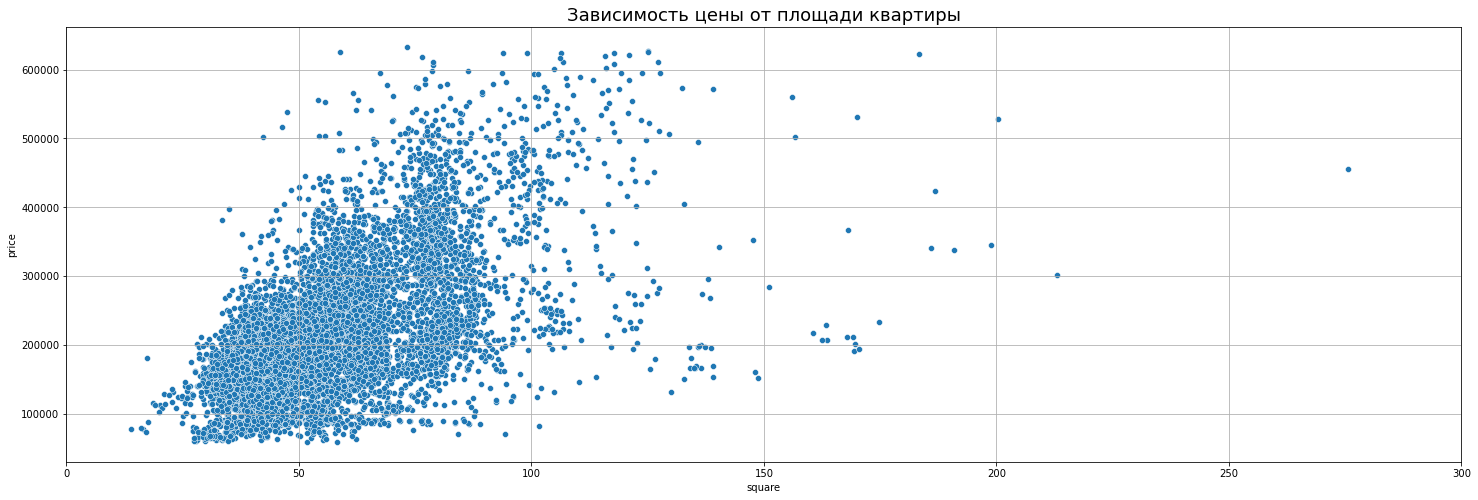

In [112]:
#Здесь также для наглядности не показываются экстремальные значения
sns.scatterplot(data=train, x = train.square, y = train.price)
plt.xlim(left=0, right=300)
plt.title('Зависимость цены от площади квартиры', fontsize=18);

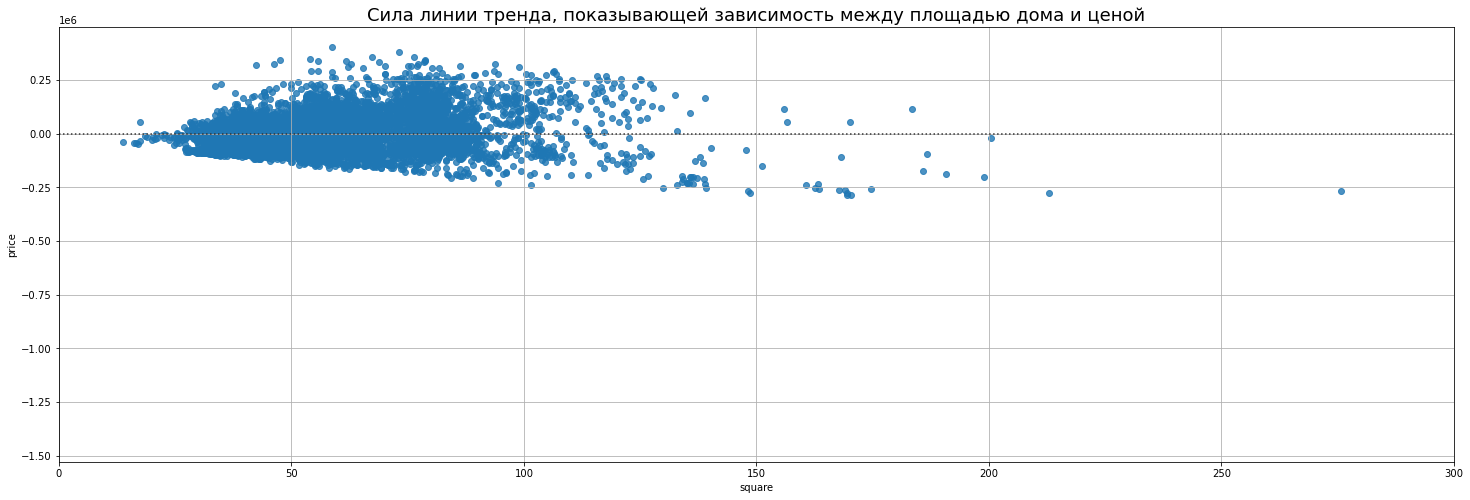

In [113]:
plt.title('Сила линии тренда, показывающей зависимость между площадью дома и ценой', fontsize=18)
plt.xlim(left=0, right=300)
sns.residplot(x=train.square, y=train.price);

Зависимость цены квартиры от ее площади имеет выраженный, но не определяющий характер. Тренд достаточно сильный, но идеальной симметрии на графике не наблюдается. На стоимость квартиры вляияют множество причин, среди которых цена является главным,но не решающим фактором.

По итогам этапа было исследовано распределение целевой переменной, установлены основные фичи, влияющие на цену, проанализирована связь фичей с таргетом и между собой

# 3. Построение модели

Для построения модели были испробованы 4 способа:
1. Линейная регрессия,
2. RandomForestRegressor,
3. CatBoost,
4. LightAutoML.
LightAutoML показал результат лучше, чем CatBoost и намного лучше, чем линейная регрессия и RandomForestRegressor.

In [114]:
task = Task('reg', loss = 'mse', metric=r2_score)
TIMEOUT = 300000
N_THREADS = 8
N_FOLDS = 4
RANDOM_STATE = 42
TARGET_NAME = 'price'
TEST_SIZE = 0.2

In [115]:
roles = {'target': TARGET_NAME, 'drop' : ['id', 'lifesquare'] }

In [116]:
#Изменил перечень алгоритмов и max_tuning_iter, чтобы добиться оптимальных результатов. Специально не смотрел блкноты участников  с высоким скором, пытался сам сделать)
automl_model = TabularAutoML(task = task, timeout=TIMEOUT, cpu_limit=N_THREADS, gpu_ids='all', reader_params={'n_jobs' : N_THREADS, 'cv' : N_FOLDS, 'random_state' : RANDOM_STATE},
                            general_params={'use_algos' :[['cb', 'cb_tuned'],['cb']], 'return_all_predictions': True},
                            tuning_params={'max_tuning_iter' : 50}
                              )

In [117]:
oof_pred = automl_model.fit_predict(train,roles=roles)

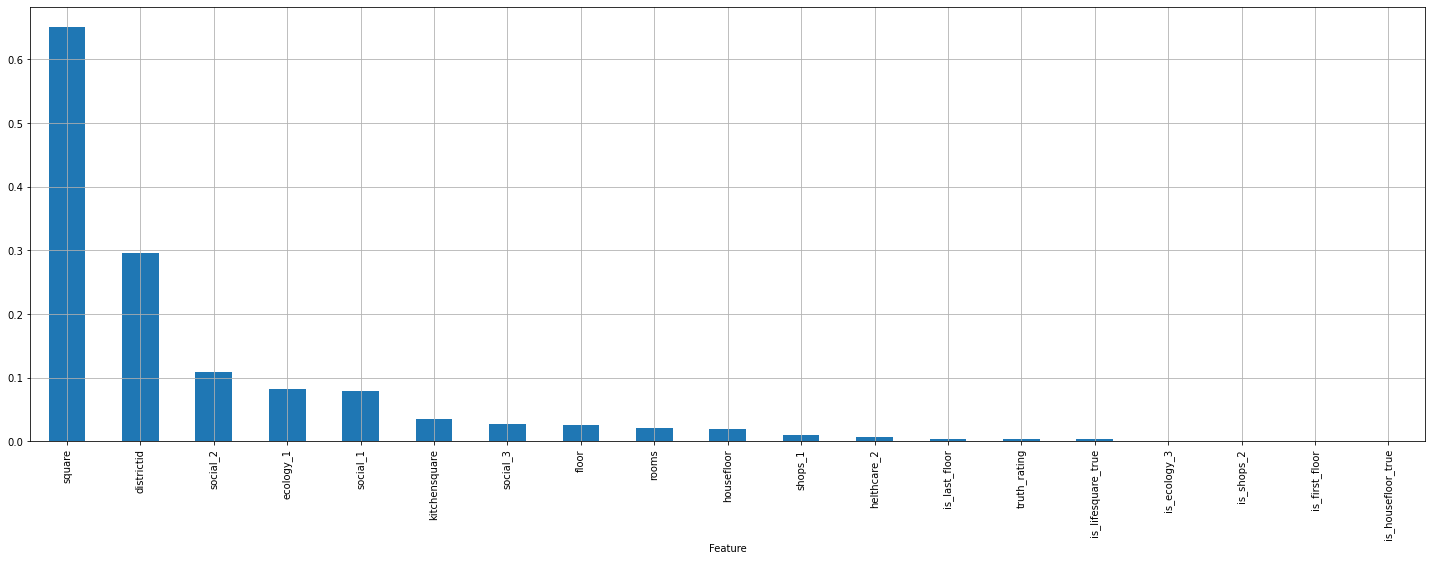

In [118]:
acc_fi = automl_model.get_feature_scores('accurate',train)
acc_fi.set_index('Feature')['Importance'].plot.bar();

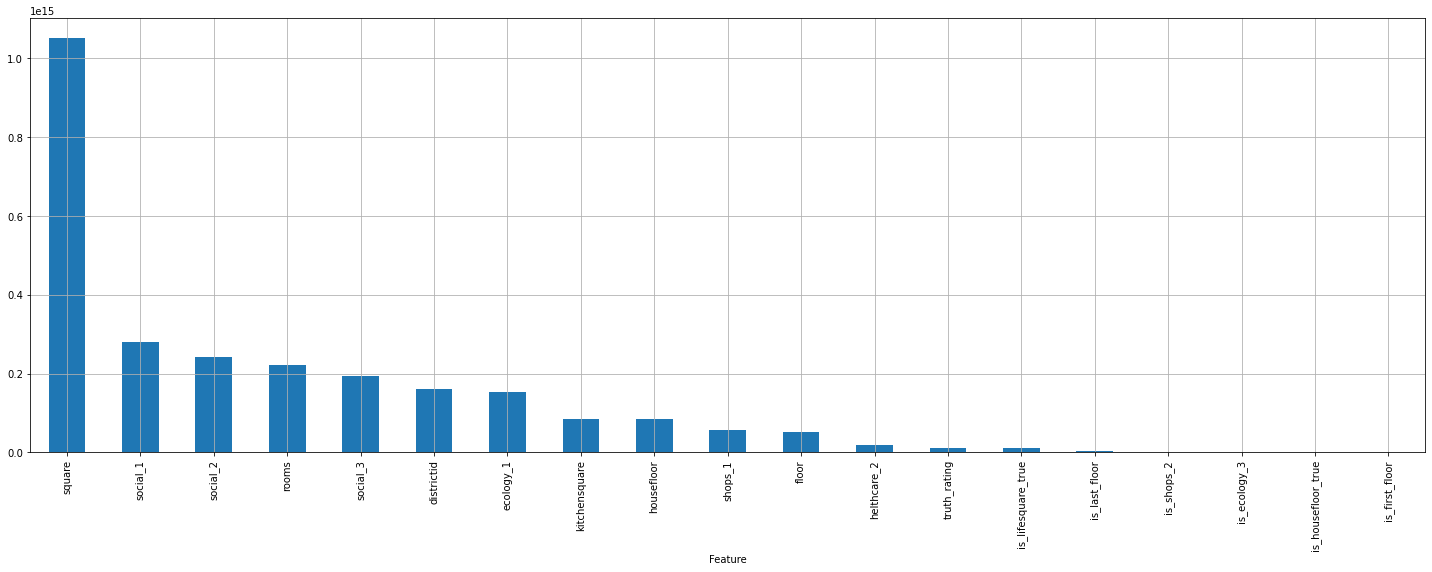

In [119]:
fast_fi = automl_model.get_feature_scores('fast',train)
fast_fi.set_index('Feature')['Importance'].plot.bar();

In [120]:
test['price'] = automl_model.predict(test).data

In [121]:
test[['id','price']].to_csv('lama_new.csv', index=False)

Бесспорно главным фактором, определяющим цену на квартиры, является ее площадь. Показатели social1, social2, ecology_1 образуют следущую по важности группу. Относительно невелико влияние площади кухни, этажа квартиры и этажности дома, но тут можно сделать скидку на низкое качество входных данных.
 Модель обеспечивает относительно неплохие показатели R2 (на трейне в процессе отработки параметров значение достигало 0.85-0.86, на тесте составило 0.751) и может быть использована для
предсказания цен на недвижимость в Москве.